In [ ]:
!pip install tensorflow
!pip install keras-retinanet
!pip install keras-resnet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp39-cp39-linux_x86_64.whl size=176582 sha256=82d0c21deb03250d9af296720c816d2bd5cbe5725c1da8a34f7ed8cd1e509d02
  Stored in directory: /root/.cache/pip/wheels/e2/c8/81/3446d987ed6b58477ac44c8a07c7253e9f38e9c96adac6364c
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20484 sha256=2378b22222f352f895bdc33b0892bfc04b72bad0044d27f2808e024e0bfa6a87
  Stored in directory: /root/.cache/pip/wheels/53/ed/ef/144804f160c278c80d6429c97ed126b61276721894ce64cccc
Successfully built keras-retinanet keras-resnet
Looking in indexes: https://pypi.

In [1]:
!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet
!pip install .
!python setup.py build_ext --inplace
%cd ..


Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6224, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 6224 (delta 6), reused 6 (delta 2), pack-reused 6205
Receiving objects: 100% (6224/6224), 13.48 MiB | 7.01 MiB/s, done.
Resolving deltas: 100% (4207/4207), done.
/content/keras-retinanet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/keras-retinanet
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp39-cp39-linux_x86_64.whl size=180745 sha256=086fc3a93d4cd024a81251b282b55ddbfe0aeedf7e48c1b4cc2a97d83f92f015
  Stored in directory: /root/.cache/pip/wheels/3f/be/fa/528d5f2773281e6dd7795aa3039aea5a871e02ab5491117ad7
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20484 sha256=2b8c20f85da3c89290c1fec07

In [2]:
import os 
import random
import shutil
from sklearn.model_selection import train_test_split


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Read images and annotations
ruta = '/content/drive/MyDrive/TFM/DroneDatasetFinal/drone_dataset_yolo/dataset_txt'
images = [os.path.join(ruta, x) for x in os.listdir(ruta) if (x[-3:] == "jpg" or x[-4:] == "JPEG")]
labels = [os.path.join(ruta, x) for x in os.listdir(ruta) if x[-3:] == "txt"]

print(len(images))
print(len(labels))

images.sort()
labels.sort()

# Split the dataset into train-valid-test splits 
train_images = images
train_labels = labels
#train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.2, random_state = 1)


4228
4228


In [6]:
!mkdir -p keras-retinanet/train/images keras-retinanet/train/annotations

In [7]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'keras-retinanet/train/images')
move_files_to_folder(train_labels, 'keras-retinanet/train/annotations')


In [8]:
#rename jpeg to jpg
source_dir = 'keras-retinanet/train/images'
files = os.listdir(source_dir)

for file in files:
    if file.lower().endswith('.jpeg'):
        old_path = os.path.join(source_dir, file)
        new_path = os.path.join(source_dir, file.lower().replace('.jpeg', '.jpg'))
        os.rename(old_path, new_path)

print('Renaming completed.')

Renaming completed.


In [22]:
#convert yolo format to retinanet annotation csv
import os
import glob
from PIL import Image

IMAGE_DIR = "keras-retinanet/train/images"
ANNOTATION_DIR = "keras-retinanet/train/annotations"
OUTPUT_FILE = "retinanet_train_annotations.csv"
CLASS_NAMES = ['drone']  # Replace with your class names

def yolo_to_retinanet(yolo_annotation, img_width, img_height):
    class_id, x_center, y_center, width, height = map(float, yolo_annotation.strip().split())

    x_min = (x_center - width / 2) * img_width
    x_max = (x_center + width / 2) * img_width
    y_min = (y_center - height / 2) * img_height
    y_max = (y_center + height / 2) * img_height

    return int(class_id), x_min, y_min, x_max, y_max

with open(OUTPUT_FILE, 'w') as output_file:
    for ann_file in glob.glob(os.path.join(ANNOTATION_DIR, '*.txt')):
        img_file = os.path.join(IMAGE_DIR, os.path.splitext(os.path.basename(ann_file))[0] + '.jpg')

        # verify whether image exists
        if not os.path.exists(img_file):
            continue

        img = Image.open(img_file)
        img_width, img_height = img.size

        with open(ann_file, 'r') as yolo_ann:
            for line in yolo_ann:
                class_id, x_min, y_min, x_max, y_max = yolo_to_retinanet(line, img_width, img_height)
                class_name = CLASS_NAMES[class_id]
                x_min = int(x_min)
                y_min = int(y_min)
                x_max = int(x_max)
                y_max = int(y_max)
                output_line = f"{img_file},{x_min},{y_min},{x_max},{y_max},{class_name}\n"
                output_file.write(output_line)

In [18]:
#train model
!keras-retinanet/keras_retinanet/bin/train.py \
  --weights keras-retinanet/snapshots/resnet50_coco_best_v2.0.1.h5 \
  --epochs 200 \
  --steps 100 \
  --batch-size 1 \
  --snapshot-path snapshots2 \
  --freeze-backbone \
  --random-transform \
  --tensorboard-dir logs \
  csv /content/retinanet_train_annotations.csv keras-retinanet/classes.csv


 # !keras_retinanet/bin/train.py --freeze-backbone \ --random-transform \ --weights {PRETRAINED_MODEL} \ --batch-size 8 \ --steps 500 \ --epochs 15 \ csv maskDetectorData.csv maskDetectorClasses.csv


2023-03-29 10:45:03.035286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 10:45:04.015330: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-29 10:45:04.015512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-29 10:45:04.015556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [32]:
!python keras-retinanet/keras_retinanet/bin/convert_model.py /content/snapshots2/resnet50_csv_196.h5 /content/keras-retinanet/inference/myModel.h5


2023-03-29 12:39:41.568634: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-29 12:39:41.568728: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-29 12:39:41.568745: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/usr/local/lib/python3.9/dist-packages/keras/initializers

In [31]:
import os
model_path = '/content/snapshots2/resnet50_csv_196.h5' #os.path.join('/content/keras-retinanet/snapshots2', sorted(os.listdir('/content/keras-retinanet/snapshots2'), reverse=True)[0])
# evaluate model using test.csv

!python /content/keras-retinanet/keras_retinanet/bin/evaluate.py \
--iou-threshold 0.5 \
--score-threshold 0.5 \
csv '/content/retinanet_test_annotations.csv' \
'keras-retinanet/classes.csv' \
{model_path} --convert-model



2023-03-29 12:38:41.683878: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-29 12:38:41.683976: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-29 12:38:41.683994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Loading model, this may take a second...
2023-03-29 12:38

In [ ]:
from keras_retinanet import models

model = models.load_model('/content/snapshots2/resnet50_csv_197.h5', backbone_name='resnet50')
model = models.convert_model(model)

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [33]:
from keras_retinanet.models import load_model

inference_model_path = '/content/keras-retinanet/inference/myModel.h5'
inference_model = load_model(inference_model_path, backbone_name='resnet50')


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [35]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras_retinanet.utils.visualization import draw_box, draw_caption , label_color
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.utils.eval import evaluate

# Load the image
image_path = '/content/keras-retinanet/0149.jpg'
image = np.array(Image.open(image_path))

# Preprocess the image
image_processed = preprocess_image(image.astype(np.float32))
image_processed, scale = resize_image(image_processed)


In [36]:
# Run the prediction
boxes, scores, labels = inference_model.predict_on_batch(np.expand_dims(image_processed, axis=0))

# Correct for the image scale
boxes /= scale


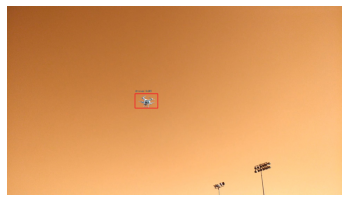

In [37]:
# Set the confidence threshold
confidence_threshold = 0.5

# Visualize the predictions
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score >= confidence_threshold:
        color = label_color(label)
        b = box.astype(int)
        draw_box(image, b, color=color)
        
        caption = f"{'drone'}: {score:.2f}"
        draw_caption(image, b, caption)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [28]:
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
val_annotations = '/content/retinanet_test_annotations.csv'
classes = 'keras-retinanet/classes.csv'
val_generator = CSVGenerator(val_annotations, classes)


In [ ]:
average_precisions, inference_time = evaluate(
    val_generator,
    inference_model,
    score_threshold=0.5,  # Set the confidence threshold
    iou_threshold=0.5,     # Set the Intersection over Union (IoU) threshold
    max_detections=100,
    save_path=None
)


Running network: 100% (10 of 10) |#######| Elapsed Time: 0:00:00 Time:  0:00:00
Parsing annotations: 100% (10 of 10) |###| Elapsed Time: 0:00:00 Time:  0:00:00


In [ ]:
print(inference_time)

0.043286895751953124


In [ ]:
# Calculate the mAP
average_precisions_dict = average_precisions[0]
num_classes = len(average_precisions_dict)
sum_ap = sum([ap[0] for ap in average_precisions_dict.values()])

mAP = sum_ap / num_classes
print(f"Mean Average Precision (mAP): {mAP:.4f}")




Mean Average Precision (mAP): 0.5878


In [34]:
import numpy as np
from sklearn.metrics import f1_score, recall_score

# Generate predictions for the validation set
y_true = []  # List to store ground truth labels
y_pred = []  # List to store predicted labels

for index in range(val_generator.size()):
    image = val_generator.load_image(index)
    annotations = val_generator.load_annotations(index)
    
    # Get ground truth labels
    gt_labels = annotations['labels']
    
    # Get predicted labels
    image = np.expand_dims(image, axis=0)
    boxes, scores, labels = inference_model.predict(image)
    
    # Apply the confidence threshold
    pred_labels = labels[0][scores[0] >= 0.5]
    
    # Make sure y_true and y_pred have the same length
    n_gt_labels = len(gt_labels)
    n_pred_labels = len(pred_labels)

    if n_gt_labels < n_pred_labels:
        gt_labels = np.pad(gt_labels, (0, n_pred_labels - n_gt_labels), mode='constant', constant_values=-1)
    elif n_gt_labels > n_pred_labels:
        pred_labels = np.pad(pred_labels, (0, n_gt_labels - n_pred_labels), mode='constant', constant_values=-1)

    y_true.extend(gt_labels)
    y_pred.extend(pred_labels)

# Calculate recall and F1 score
recall = recall_score(y_true, y_pred, average='weighted', labels=np.unique(y_true))
f1 = f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_true))

print("Recall:", recall)
print("F1 score:", f1)




1/1 [==============================] - 1s 1s/step
Recall: 0.40707964601769914
F1 score: 0.46084488228418763


In [ ]:
#Prueba con un video de Youtube
!pip install pytube

In [ ]:
#Descargamos el video de prueba dónde aparecen drones

from pytube import YouTube

video_url = 'https://www.youtube.com/watch?v=0Wd7ZhGSkRo'
output_path = 'video.mp4'

try:
    yt = YouTube(video_url)
    video_stream = yt.streams.filter(file_extension='mp4', res='360p').first()
    video_stream.download(filename='video', output_path='')
    print("Video descargado correctamente")
except Exception as e:
    print("Error al descargar el video")
    print(e)

In [ ]:
#extraemos los fotogramas
import cv2

def get_total_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total_frames

video_path = 'video'
total_frames = get_total_frames(video_path)
print(f"El video tiene {total_frames} fotogramas")

In [ ]:
#Guardamos los fotogramas en una carpeta
import cv2
import os

def extract_frames(video_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    success = True

    while success:
        success, frame = cap.read()

        if not success:
            break

        frame_path = os.path.join(output_folder, f'frame{frame_count:04d}.png')
        cv2.imwrite(frame_path, frame)
        frame_count += 1
        print(f"Guardando fotograma {frame_count} en {frame_path}")

    cap.release()

video_path = 'video'
frames_folder = 'frames'
extract_frames(video_path, frames_folder)

In [ ]:
#probamos difersos frames del video con nuestro modelo
import time
from IPython.display import clear_output
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras_retinanet.utils.visualization import draw_box, draw_caption, label_color
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.utils.eval import evaluate

# Carga tu modelo
# model = ...

frames = os.listdir(frames_folder)
frames.sort()

for frame_file in frames:
    frame_path = os.path.join(frames_folder, frame_file)
    image = np.array(Image.open(frame_path))

    # Preprocesa la imagen
    image_processed = preprocess_image(image.astype(np.float32))
    image_processed, scale = resize_image(image_processed)

    # Procesa la imagen con tu modelo
    boxes, scores, labels = inference_model.predict_on_batch(np.expand_dims(image_processed, axis=0))

    # Escala las cajas al tamaño original de la imagen
    boxes /= scale

    # Set the confidence threshold
    confidence_threshold = 0.5

    # Visualize the predictions
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score >= confidence_threshold:
            color = label_color(label)
            b = box.astype(int)
            draw_box(image, b, color=color)
            print(score)
            caption = f"{'drone'}: {score:.2f}"
            draw_caption(image, b, caption)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Pausa para simular tiempo real (ajusta el valor según la velocidad de fotogramas del video)
    time.sleep(0.1)
    clear_output(wait=True)

In [ ]:
#convert yolo format to retinanet annotation csv
import os
import glob
from PIL import Image

IMAGE_DIR = "/content/sample_data/images"
ANNOTATION_DIR = "/content/sample_data/annotations"
OUTPUT_FILE = "retinanet_annotations.csv"
CLASS_NAMES = ['drone']  # Replace with your class names

def yolo_to_retinanet(yolo_annotation, img_width, img_height):
    class_id, x_center, y_center, width, height = map(float, yolo_annotation.strip().split())

    x_min = (x_center - width / 2) * img_width
    x_max = (x_center + width / 2) * img_width
    y_min = (y_center - height / 2) * img_height
    y_max = (y_center + height / 2) * img_height

    return int(class_id), x_min, y_min, x_max, y_max

with open(OUTPUT_FILE, 'w') as output_file:
    for ann_file in glob.glob(os.path.join(ANNOTATION_DIR, '*.txt')):
        img_file = os.path.join(IMAGE_DIR, os.path.splitext(os.path.basename(ann_file))[0] + '.jpg')
        img = Image.open(img_file)
        img_width, img_height = img.size

        with open(ann_file, 'r') as yolo_ann:
            for line in yolo_ann:
                class_id, x_min, y_min, x_max, y_max = yolo_to_retinanet(line, img_width, img_height)
                class_name = CLASS_NAMES[class_id]
                output_line = f"{img_file},{x_min},{y_min},{x_max},{y_max},{class_name}\n"
                output_file.write(output_line)



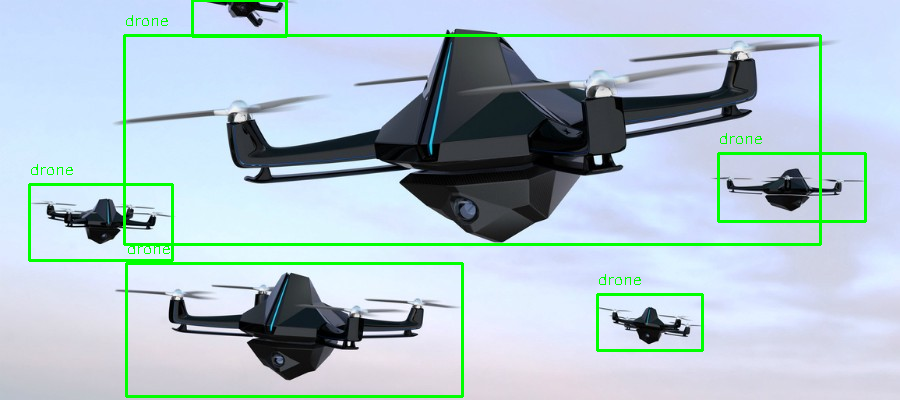

In [ ]:
#visualizar las imagenes con su bbox
import cv2
import pandas as pd
import os
from google.colab.patches import cv2_imshow
IMAGE_DIR =  "/content/sample_data/images"
ANNOTATION_CSV = '/content/retinanet_annotations.csv'
IMAGE_NAME = '0001.jpg'  # Replace with the image name you want to display

def display_image_with_bounding_boxes(image_path, annotations_df):
    img = cv2.imread(image_path)
    for _, row in annotations_df.iterrows():
        x_min = int(row['x_min'])
        y_min = int(row['y_min'])
        x_max = int(row['x_max'])
        y_max = int(row['y_max'])
        class_name = row['class_name']
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        img = cv2.putText(img, class_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    cv2_imshow(img)

annotations = pd.read_csv(ANNOTATION_CSV, names=['image_path', 'x_min', 'y_min', 'x_max', 'y_max', 'class_name'])

image_path = os.path.join(IMAGE_DIR, IMAGE_NAME)
image_annotations = annotations[annotations['image_path'] == image_path]
display_image_with_bounding_boxes(image_path, image_annotations)